# Data Mining Handin 1
This handin is about clustering algorithms.

The handin is mandatory, and should be done in groups of 2-3 students. Each group
must prepare a report in PDF format as outlined below. Please submit all your
Python files in a zip file, and your PDF report outside the zip file, to
Blackboard no later than **March 3rd kl. 14.14**.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

from sklearn.decomposition import PCA
from sklearn.datasets import make_moons

import sys
sys.path.append('..')
from utilities.load_data import load_iris_PC, load_t7, load_synthetic_data

# 1. Theoretical Questions

**Report section 1:**  
a) Please describe the KDD process. 

b) Please explain what Data Mining is, and compare it with Machine Learning. 

c) Please define clustering, subspace clustering, and hierarchical clustering.

d) Please discuss similarities and differences between clustering and unsupervised outlier detection 

e) Consider the following scenario: you have been asked to provide a subspace clustering of a data set. Since you already have an implementation of PCA for dimensionality reduction and a full space clustering (such as k-means or DBSCAN, the precise choice is not relevant for this question) available, you consider just using PCA and then full space clustering. Are the results expected to be similar? Why/why not? 

## 2. Implementing the Algorithms

In this section, you must implement the DBSCAN algorithm and the SUBCLU algorithm.

### 2.1 DBSCAN
First thing you will be implementing is the DBSCAN algorithm.
You are allowed to structure your code however you want. 
The code below is inspired by [Zaki, p. 377] and serves as inspiration.
Note, you are allowed to copy any code you produced during class.

In [64]:
def L2_norm(x, y):
    return np.sqrt(np.sum((x-y)**2))

def densityConnected(x, k, X, clusters, core): # You might need more parameters here.
#     print('in dc 1')
    for cluster in clusters:
        if x in cluster:
            return
    
    clusters[-1] += [x]
    for neighbor in core[x]:
        # Connect (potentially recursively)
#         print()
#         print('in dc', clusters)
#         print()
#         clusters[-1] += [neighbor]
        densityConnected(neighbor, k, X, clusters, core)
        

def neighborhood(x, X, eps):
    neighbors = []
    for i in range(len(X)):

        if L2_norm(x, X[i]) <= eps:
            neighbors += [i]
    return neighbors

def dbscan(X, eps, minpts, dist_fn=L2_norm):
    """
        Args:
            X:         Matrix of shape [n, d] with data points on the rows.
            eps:       Epsilon distance for neighborhood calculations.
            minpts:    Minimum neighbors in epsilon neighborhood for a point to be a core point.
            dist_fn:   Distance function to be used.
        
        Returns:
            clusters:   A vector of shape [n,] with integers, indicating cluster assignments.
                        Let clusters[i] == -1 if point x_i is an outlier and a non-negative 
                        integer corresponding to the cluster index of point x_i otherwise.
    """
    
    # TODO, code here.
    N = len(X)
    print(N)
    core = [[] for _ in range(N)]
    for i in range(len(X)):
        n = neighborhood(X[i], X, eps)
#         print(n)
        if len(n) >= minpts:
            core[i] = n
#     print(core)
    k = 0
    fake_clusters = []
    for i in range(len(core)):
        if len(core[i]) > 0:
            fake_clusters += [[]]
#             print(fake_clusters)
            densityConnected(i, k, X ,fake_clusters, core)
            # Assign unassigned cores to clusters
            # using densityConnect
    
#     k = len(fake_clusters)
#     print(fake_clusters)
    clusters = [-1 for o in range(N)]
    k = 1
    for i in range(len(fake_clusters)):
        # Build cluster indicator vector
        for point in fake_clusters[i]:
            clusters[point] = k
        if len(fake_clusters[i]) > 0: 
            k += 1
    
    # End TODO
    
    return clusters

# clustering = dbscan(X, 5, 1)
X, _ = load_t7()
n, _ = X.shape
np.random.seed(0)
X = X[np.random.permutation(n)]
X = X[:50]
clustering = dbscan(X, 15, 2)

C:\Users\Fatemeh\Documents\AU\Data_Mining\dm20_exercises\utilities/data/t7-4k.txt
50


#### Verify that your algorithm works
Below, we have made a small script that allows you to run your algorithm on the small 2D Iris data set and on the larger 2D data set from [Zaki, p. 376].

C:\Users\Fatemeh\Documents\AU\Data_Mining\dm20_exercises\utilities/data/t7-4k.txt
2000


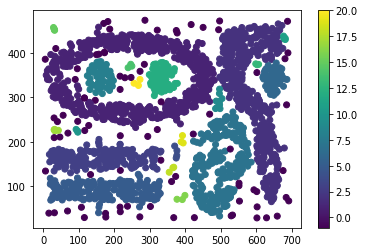

In [69]:
# Test clustering on iris_PC dataset
slow = True
if slow:
    X, _ = load_t7()
    n, _ = X.shape
    np.random.seed(0)
    X = X[np.random.permutation(n)]
    X = X[:2000]
    clustering = dbscan(X, 15, 3)
else: 
    X, _ = load_iris_PC()
    clustering = dbscan(X, 0.4, 5)

fig, ax = plt.subplots(1, 1)
sc = ax.scatter(*(X.T), c= clustering)
plt.colorbar(sc)
plt.show()

## 1.2 DBSCAN with Gaussian kernel
As in the exercises of Week 3, we are going to alter the DBSCAN algorithm to use another kernel.

As stated in [Zaki, p.388], DBSCAN is a special case of DENCLUE.
In particular, if we let $h=\epsilon$ and $\xi = minPts$ with a discrete kernel, then the two algorithms will yield the same result.

We are now going to go a step in the other direction.
Thas is, we will add a Gaussian kernel to the DBSCAN algorithm.
The Gaussian kernel is defined as in Equation (1).

$$
K(\mathbf{z})=\frac{1}{(2 \pi)^{d / 2}} \exp \left\{-\frac{\mathbf{z}^{T} \mathbf{z}}{2}\right\}
\qquad \qquad (1)
$$

The implications in terms of the algorithm are the following:

1. When selecting core points, they are now going to depend on a threshold $\xi$ of the density estimates $\hat f(x)$.
2. The threshold $\epsilon$ is now going to be compared against $K(\frac{x-x_i}{h})$ when calculating neighborhoods and density connectedness.
3. The value $h$ which was previously fixed to $\epsilon$ is now going to be a parameter to the model.

As before, the code below serves as inspiration.

In [ ]:
def K(z):
    return  np.exp(-np.dot(z, z)/2) / np.sqrt(2*np.pi)

def densityConnected(x, k, ...): # You might need more parameters here.
    for neighbor in x.Nx:
        # Connect (potentially recursively)
        pass

def gaussian_dbscan(X, e, xi, h):
    """
        Args:
            X:       Matrix of shape [n, d] with data points on the rows.
            e:       Epsilon distance for neighborhood calculations.
            m:       Minimum neighbors in epsilon neighborhood for a point to be a core point.
            dist_fn: Distance function to be used.
        
        Returns:
            clusters:   A vector of shape [n,] with integers, indicating cluster assignments.
                        Let clusters[i] == -1 if point x_i is an outlier and a non-negative 
                        integer corresponding to the cluster index of point x_i otherwise.
    """
    
    # TODO, code here.
    
    core = []
    for x in X:
        # Compute neighborhoods and identify cores
        pass

    k = 0
    for c in core:
        # Assign unassigned cores to clusters
        # using densityConnect
        pass

    clusters = []
    for i in range(k):
        # Build cluster indicator vector
        pass
    
    # End TODO
    
    return clusters

clustering = gaussian_dbscan(X, 5, 1)

#### Verify that your algorithm works
Below, we have made a small script that allows you to run your algorithm on the small 2D Iris data set.

In [ ]:
# Test clustering on iris_PC data and density-based data
slow = True
if slow:
    X, _ = load_t7()
    n, _ = X.shape
    np.random.seed(0)
    X = X[np.random.permutation(n)]
    X = X[:2000]
    h = 3.25
    clustering = gaussian_dbscan(X, e=0.0001, xi=0.4, h=h)
else: 
    X, _ = load_iris_PC()
    h = 0.7
    clustering = gaussian_dbscan(X, 0.2, 12., h)

fig, ax = plt.subplots(1, 1)
sc = ax.scatter(*(X[clustering >= 0].T), c=clustering[clustering>=0])
sc = ax.scatter(*(X[clustering < 0].T), marker='x')
plt.colorbar(sc)
plt.show()

## 1.3: Subspace Clustering
The last algorithm that you need to implement is the bottom-up algorithm SUBCLU. 

As SUBCLU utilizes the DBSCAN algorithm (potentially a lot of times), it might be slow if you use your own implementation above. Therefor, you are also allowed to use [scipy.cluster.dbscan](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.dbscan.html) to speed up things a bit.
 
The code below serves a inspiration and may be used.

In [ ]:
# YOUR CODE HERE
from sklearn.cluster import dbscan

def _overlap(l1, l2):
    """
        - - Helper function - -
        Given two arrays of integets (l1 and l2), this function returns the overlapping set, if 
        the two arrays differs on exactly one integer each. If the two arrays differ on more,
        None will be returned.
        Examples:
            _overlap([1, 2], [2, 3])       -> [1, 2, 3]
            _overlap([6, 3, 1], [6, 4, 3]) -> [1, 3, 4, 6]
            _overlap([1, 2], [3, 4])       -> None
    """
    if not len(l1) == len(l2): raise ValueError("l1 and l2 should be the same length but were %i and %i, respectively" % (len(l1), len(l2))) 
        
    l1 = sorted(l1)
    l2 = sorted(l2)

    i, o1, o2 = 0, 0, 0
    overlap = []
    while max(i+o1, i+o2) < len(l1):
        if o1 > 1 or o2 > 1: return None
        if l1[i+o1] < l2[i+o2]: 
            overlap.append(l1[i+o1])
            o1 += 1
        elif l2[i+o2] < l1[i+o1]:
            overlap.append(l2[i+o2])
            o2 += 1
        else:
            overlap.append(l1[i+o1])
            i+=1
    if i+o1 < len(l1): overlap.append(l1[i])
    if i+o2 < len(l2): overlap.append(l2[i])

    return overlap

def _supspace_spans(s, a):
    """
        - - Helper function - -
        Given two arrays of integers (s and a), the function return True if
        a is (strict) subset of s.
        Examples:
            _subspace_spans([1, 2, 3], [1, 2])  -> True
            _subspace_spans([1, 2, 3], [1])     -> True
            _subspace_spans([1, 2, 3], [4])     -> False
            _subspace_spans([1, 2], [1,2])      -> False
    """
    if len(s) <= len(a): return False
    s = sorted(s)
    a = sorted(a)
    offset = 0
    for i in range(len(a)):
        found = False
        while i+offset < len(s) and not found: 
            found = s[i+offset] == a[i]
            if not found and offset == 0: offset += 1
            elif not found: return False
        if not found and i < len(a) - 1: return False
    return True

def _candidate_subspace(Si):
    """
        Function should return a list of candidate subspaces.
    """
    # TODO
    pass
    
def subclu(X, e, m):
    """
        Args:
            X:       Matrix of shape [n, d] with data points on the rows.
            e:       Epsilon distance for neighborhood calculations.
            m:       Minimum neighbors in epsilon neighborhood for a point to be a core point.
        
        Returns:
            A tuple (S, C) of subspaces and clusters
            S:       A list of lists, each contining the indexes of the subspaces.
            C:       A list of lists, each containing clustering for the corresponding subspace.
            
    """
    n, d = X.shape
    Si = []
    Ci = []
    
    # First iteration with 1d subspaces
    for a in range(d):
        # TODO 
    
    while len(Si) > 0:
        Si_new = []
        Ci_new = []

        candidates = _candidate_subspace(Si)
        for cand in candidates:
            best_subspace = -1 # index of best subspace
            min_cost = 999999999

            for i, subspace in enumerate(Si):
                if _supspace_spans(cand, subspace):
                    # TODO Find best subspace

            C_cand = []
            cluster = Ci[best_subspace]
            subspace = Si[best_subspace]
            for i in range(cluster.max()):
                # TODO calculate cluster and append if all points are not classified as outliers
                
        if len(Si_new) > 0:
            Si = Si_new
            Ci = Ci_new
        else: 
            # Break if no larger subspaces should be considered
            break
    return Ci, Si

To test that the SUBCLU algorithm works, we will need to use some data, which have clusters in some subspaces.
We will use some synthetic data, which was introduced by [1].
The data we will use is 10-dimensional and has multiple subclusters in 2-dimensional subspaces.
Below, we have provided some code, which will run the `subclu` procedure above and plot the found clusters in the associated subspaces.
It will also plot the clusters on the 2d PCA projection of the data.
You may want to include a similar plot in your report for the question above about PCA and subspace clustering (it is not required though).

[[1]](https://ieeexplore.ieee.org/abstract/document/6228154) Keller, F., Muller, E. and Bohm, K., 2012, April. HiCS: High contrast subspaces for density-based outlier ranking. In 2012 IEEE 28th international conference on data engineering (pp. 1037-1048). IEEE.

In [ ]:
X, y = load_synthetic_data()
X_2d = PCA(n_components=2).fit_transform(X)
C, S = subclu(X, 0.012, 30)
print("Resulting S: ", S)
print("Resulting unique clusters")

rows, cols = 2, 6
fig, ax = plt.subplots(rows*2, cols, figsize=(4*cols, 8*rows))

for i, (s, c) in enumerate(zip(S, C)):
    unique, cnt = np.unique(c, return_counts=True)
    print("%i\t Num clusters: %i\t Points pr. group %s" % (i, unique.shape[0]-1, str(cnt)))
    
    if not len(s) == 2: continue # Can only plot 2d subspaces
    
    if i < rows * cols: 
        p = i // cols
        q = i % cols
        sc = ax[2*p,q].scatter(X[:,s[0]], X[:,s[1]], c=c)
        ax[2*p+1,q].scatter(*(X_2d.T), c=c)
        
        sc = ax[2*p,q].scatter(X[c>=0,s[0]], X[c>=0,s[1]], c=c[c>=0])
        ax[2*p,q].scatter(X[c<0,s[0]], X[c<0,s[1]], marker='x')
        
        ax[2*p+1,q].scatter(*(X_2d[c>=0].T), c=c[c>=0])
        ax[2*p+1,q].scatter(*(X_2d[c<0].T), marker='x')
        
        if q == cols-1 and p == 0: 
            fsc = sc
            fax = ax[2*p,q]
fig.tight_layout()
fig.colorbar(sc, ax=fax)
plt.show()


**Report section 2:**
- Please explain how the three algorithms differ theoretically.
- In what situations (or for what kind of data) would you expect each of the algorithms to be better?

## 3. Evaluating clusterings

Implement the F1 score and the silhouette coefficient, and compare the quality of
several runs of your algorithms with proper hyper parameters.

You will need labels to compute the F1 score. 
For this task, we will use the half moon data generated below. 

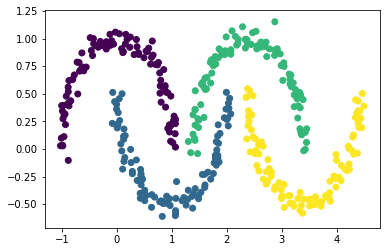

In [2]:
# Load the Iris data set
X1, y1 = make_moons(n_samples=200, shuffle=True, noise=.06)
X2, y2 = make_moons(n_samples=200, shuffle=True, noise=.06)

X2[:,0] += 2.4
y2 += 2

X = np.concatenate([X1, X2], axis=0)
y = np.concatenate([y1, y2], axis=0) / 4.

fig, ax = plt.subplots(1, 1)
ax.scatter(*(X.T), c=y)
plt.show()

## 3.1 Silhouette Coefficient
Implement the Silhouette coefficient as explained during the lectures. Explanations can be found both on slides and in the book. You can use the following template

In [ ]:
def silhouette(data, clustering): 
    n, d = data.shape
    k = np.max(clustering)+1

    # YOUR CODE HERE
    silh = None
    # END CODE

    return silh


Try to run the [Kmeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.k_means.html) algorithm (from scikit learn) with different values of $k$ and the DBSCAN algorithm with different values of $\epsilon$ and $\text{minPts}$, and compute the silhouette coefficient for each.

You could use the following template.

In [ ]:
from scipy.cluster import k_means

print("K-means")
for k in range(2, 10):
    _, clusters = k_means(X, k)
    # sc = silhouette(...)
    print(k, sc)

print("DBSCAN")
for e in [0.1 + i * 0.1 for i in range(10)]:
    for minPts in range(2, 8):
        #... = dbscan(X, e, minPts)
        # sc = silhouette(...)
        print(e, minPts, sc)

**Report 3.1:**  
- Include a tabel that holds the silhouette coefficient for the above experiment$^*$.
- Which of the two algorithms performs better? 


$^*$ The `tabulate` package might come in handy for producing tables of results.

## 3.2 F1 Score
Implement a function that computes the F1 score. 

You can use the following template.

In [84]:
def contingency_table(predicted, labels):
    table = np.array([[0 for _ in range(np.max(labels) + 1)] for _ in range(np.max(predicted) + 1)])
    
    for partition in labels:
        for cluster in predicted:
            if (partition == cluster):
                table[cluster][partition] += 1
    
    return table


def recall(contingency_table):
    mj = np.sum(contingency_table, axis=1)
    recall = np.array([])
    
    for prediction_label in contingency_table:
        max_prediction_index = np.argmax(prediction_label)
        recall_at_index = prediction_label[max_prediction_index] / mj[max_prediction_index]
        np.append(recall, recall_at_index)
    
    return recall
            

def precision(contingency_table):
    nj = np.sum(contingency_table, axis=0)
    precision = np.array([])
    
    
    for partition_label in contingency_table.T:
        max_prediction_index = np.argmax(partition_label)
        precision_at_index = partition_label[max_prediction_index] / nj[max_prediction_index]
        np.append(precision, precision_at_index)
    
    return precision


def f1(predicted, labels):
    n, = predicted.shape
    assert labels.shape == (n,)
    r = np.max(predicted) + 1
    k = np.max(labels) + 1


    # Implement the F1 score here
    # YOUR CODE HERE
    contingency = contingency_table(predicted, labels)
    prec = precision(contingency)
    reca = recall(contingency)
    
    print(reca, prec)
    
    
    F_individual = (2 / (1 / prec) + (1 / reca))
    F_overall = None
    # END CODEp
    assert contingency.shape == (r, k)
    return F_individual, F_overall, contingency

p = np.array([1, 2, 3])
l = np.array([1, 2, 4])

f1(p, l)

[] []


c:\users\fatemeh\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars
c:\users\fatemeh\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars


(array([], dtype=float64), None, array([[0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0]]))

Make a similar experiment as the one for the silhouette coefficient. 

In other words: try to run the [Kmeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.k_means.html) algorithm (from scikit learn) with different values of $k$ and the DBSCAN algorithm with different values of $\epsilon$ and $\text{minPts}$, and compute the F1-score for each.

In [ ]:
print("K-means")
for k in range(2, 10):
    _, clusters = k_means(X, k)
    # f1 = f1(...)
    print(k, sc)

print("DBSCAN")
for e in [0.1 + i * 0.1 for i in range(10)]:
    for minPts in range(2, 8):
        #... = dbscan(X, k, 50)
        # f1 = f1(...)
        print(e, minPts, sc)

**Report section 3.2:**
- Include a tabel that holds the F1-scores for the above experiment.
- Which of the two algorithms performs better? 

**Report section 3.3:**  
- Are any of the two evaluation measures (F1 score, Silhouette Coefficient) biased towards DBSCAN or k-means? If so, which one(s) favours which  algorithm(s) and how?
- Consider the use of F1 score to evaluate SUBCLU - does the score accurately reflect the clustering notion of SUBCLU or what kind of changes would be needed for a proper evaluation?

## Deliverables
As part of the handin you must submit the following.

### Code
You must include a `.py` file including your implementations of the three algorithms (DBSCAN x2, SUBCLU) and the two evaluation measures (Silhouette coefficient and F1 score). Alternatively, you could code everything in here and upload the final IPython Notebook. 

### Report
Your report should be 1-3 pages and clearly state who is in the group. It must cover:

* Summary/Abstract: The status of the work, i.e., does it work, if not, then why.
* Answers to the report sections stated above.
